# AMLD-2021-Sketchy: Web App APIs

In this notebook, we reproduce the different API calls of the web app and code along similar functionnalitites.

You willl need to have the server running.

In [78]:
training_name = "quickdraw" # name of the trained model we use
max_epoch = "00012" # final epoch of the training

In [63]:
# !python src/api/server.py quickdraw

In [104]:
import os
import base64
import io
import json
import random
import requests

from cairosvg import svg2png
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import plotly.graph_objects as go
from sklearn.decomposition import PCA

from src.data.utils import default_image_loader

##  Receive an svg string

In the web app the user draws a sketch and then this sketch is sent as an svg string in base 64 encoding to the back-end. 

Here, the back end receives an dictionnary with a key `sketch` and the associated value `svg_string` (base 64 encoding of the image). To pass this sketch through the encoder netowrk, we need to convert the base 64 encoded string to a png image (with `svg_to_png`).

In [44]:
def svg_to_png(sketch):
    """ Convert a sketch in svg format to an image array """
    # random name
    random_number = str(random.random())
    sketch_fname = "sketch" + random_number + ".png"

    # make png
    svg2png(bytestring=sketch, write_to=sketch_fname)

    # add white background
    im = Image.open(sketch_fname)
    im = im.convert("RGBA")
    background = Image.new(im.mode[:-1], im.size, (255, 255, 255))
    background.paste(im, im.split()[-1])  # omit transparency
    background.convert("RGB").save(sketch_fname)

    sketch = default_image_loader(sketch_fname)
    os.remove(sketch_fname)

    return sketch

Here, instead of drawing an image in the web app and sending it to the server, we saved json files with data in a similar format as what the server receives. In the folder `svg` there are 3 choices: 'amld' written in letters, a pineapple and a raccon. You can change the `index` value below between 0 and 2 to choose your sketch.

In [45]:
# Modify the index value. 0 dor AMLD, 1 for pineapple, 2 for racoon.
index = 2
assert ((isinstance(index, int)) and (0 <= index <= 2)), "The index must be 0, 1 or 2"

svg_folder = 'svg/'
svg_files = ['amld', 'pineapple', 'racoon']
path = svg_folder + svg_files[index] + '.json' # choose any

In [46]:
with open(path, 'r') as fp:
    data = json.load(fp)

In [47]:
svg_string = data['sketch']

We can convert the sketch string and plot it.

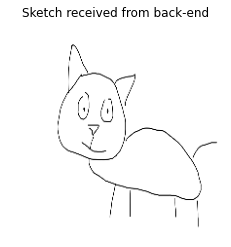

In [48]:
sketch = svg_to_png(svg_string)
plt.imshow(sketch);
plt.title('Sketch received from back-end')
plt.axis("off");

## List of APIs

There are many different api calls. /api_list lists them:

In [61]:
res = requests.get("http://127.0.0.1:5000/api_list")
apis = res.json()['available-apis']
for api in apis:
    print(api['api-key'])
    print(api['description'])
    print('\n')

cmd: /api_list
Input: None. Return the list of available commands.


cmd: /find_images
Input: an svg base 64 string of a sketch. Returns base 64 string of its closest images, the associated labels and the attention map


cmd: /get_embeddings
Inputs: a dimension number (2 or 3) and optinally a sketch. Returns the projected points of the embeddings.


cmd: /get_dataset_images
Input: a category name. Returns 5 random images and sketches of this category.


cmd: /get_embedding_images
Input: a class and clicked position. Returns the closest image to the clicked position.


cmd: /scalar_perf
Input: None. Returns the values of the loss and metrics during training.


cmd: /image_perf
Input: an image type (inference, sketch or image attention). Returns how the model performed at each epoch of the training.




Can you guess which api calls match with which page and functionnality of the web app ?

We will code here some of the functions equivalent to those of the web app or the server.

## Inference: return closest images of sketch

We send an svg drawing to the server form the web app.

In [64]:
data = {"sketch": svg_string}
res = requests.post("http://127.0.0.1:5000/find_images", json=data).json()

In the back-end, the svg is converted into a png and a white background is added. Then the inference function gets the 2 closest images and the associated attention map (very similar to what we did in the notebook with the performance). These are all returned as a response from the api call.

In [65]:
images_base64 = res['images_base64']
images_labels = res['images_label']
attention = res['attention']

The returned data is encoded in base64 strings, we convert it back to an array.

In [68]:
def base64_to_array(base64_string):
    '''
    Converts a returned base 64 string of an image into a numpy array
    Args: 
        - base64_string: base 64 encoding of the image
    Return:
        - numpy array of the image
    '''
    base64_string = base64_string.split("'")[1]
    image = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(image))
    return np.array(image)

In [69]:
image1 = base64_to_array(images_base64[0])
image2 = base64_to_array(images_base64[1])
attention = base64_to_array(attention)

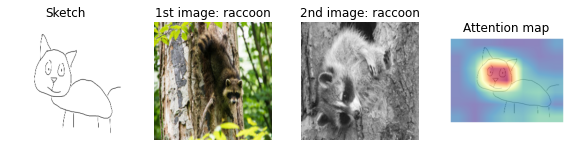

In [70]:
fig, axes = plt.subplots(1, 4, figsize=(10, 8))
axes[0].set(title='Sketch')
axes[0].imshow(sketch)
axes[0].axis("off");

axes[1].set(title=f'1st image: {images_labels[0]}')
axes[1].imshow(image1)
axes[1].axis("off");

axes[2].set(title=f'2nd image: {images_labels[1]}')
axes[2].imshow(image2)
axes[2].axis("off");

axes[3].set(title=f'Attention map')
axes[3].imshow(attention)
axes[3].axis("off");
plt.subplots_adjust(wspace=0.25, hspace=-0.35)

## Embeddings: get 2D or 3D projection of the embeddings' PCA.

The `/get_embedding` function returns the 2D or 3D PCA projection of a selected number of images embeddings.

- It must receive the number of dimension `nb_dim` that is either 2 or 3 (for 2D or 3D).
- If it receives an svg sketch in `sketch` then it also computes the PCA with this sketch and also return the sketch's projected position in the category "My Custom Sketch".

We show here how to do the 2D plot with the associated custom sketch embedding. 

In [71]:
data = {"nb_dim": 2, "sketch": svg_string}
res = requests.post("http://127.0.0.1:5000/get_embeddings", json=data).json()

In [72]:
colors = ["#e6194b","#3cb44b","#ffe119","#4363d8","#f58231",
          "#911eb4","#46f0f0","#f032e6","#bcf60c","#fabebe",
          "#008080","#e6beff","#9a6324","#fffac8","#800000",
          "#aaffc3","#808000","#ffd8b1","#000075","#808080","#000000"]

In [76]:
traces = []
fig = go.Figure()
for i, (category, coordinates) in enumerate(res.items()):
    if category == "My Custom Sketch":
        marker_size=12
    else:
        marker_size=6
    trace = go.Scatter(
        x=coordinates['x'],
        y=coordinates['y'],
        name=category,
        mode='markers',
        marker_color=colors[i], 
        marker_size=marker_size,
        hoverinfo= "name",
    )
    fig.add_trace(trace)
    fig.update_layout(title='2D plot of the embeddings (projected with the PCA)')
    
fig.show()

The backend now receives a request to see the same embeddings but displayed in 3D, we must return the embeddings of the model (with are in the 256 dimensional embedding space) to visualise them.

In [98]:
nb_dimension = 3    # the visalisation must be in 3D
show_sketch = False # this time we do not send a sketch

During training we logged metadata in the folder of the model. There we can find the model checkpoints as well as many tensorboard logs such as the logs for the embeddings that we were able to visualise in tensorboard's projector.

Overall, tensorboard saves the embedding metadata in 3 different files which contain the ordered labels, images and embeddings.

    - sprite.png: very large image containing the sketches and images next to each others
    - metadata.csv: each row contains the label of the associated sketch or images in sprite.png
    - tensors.tsv: earch row contains an embedding of the associated sketch or images in sprite.png

To get the 'raw' embedding data (still in 256 dimensions) with their classes, we need to process the files `tensors.tsv` and the `metadata.tsv` in the last epoch of training in the training folder of the model.

In [82]:
folder = f"/io/models/{training_name}/{max_epoch}/default/"
tensors_path = folder + "tensors.tsv"
classes_path = folder + "metadata.tsv"

We read the classes and store them in a list.

In [91]:
with open(classes_path, "r") as f:
    classes = [line.rstrip("\n") for line in f]

We read the raw embeddings and store the embeddings in an array.

In [83]:
def read_tensor_tsv_file(fpath):
    """Read the tensors file:  earch row contains an embedding"""
    with open(fpath, "r") as f:
        tensor = []
        for line in f:
            line = line.rstrip("\n")
            if line:
                tensor.append(list(map(float, line.split("\t"))))
    return np.array(tensor, dtype="float32")

In [110]:
tensors = read_tensor_tsv_file(tensors_path)
print(f"There are {tensors.shape[0]} samples of dimension {tensors.shape[1]}.")
print(f"{int(tensors.shape[0]/2)} sketches and {int(tensors.shape[0]/2)} images.")

There are 500 samples of dimension 256.
250 sketches and 250 images.


**TODO** Project the embeddings from 256D to 3D. Feel free to use an algorithm of your choice. The back-end of the web app implements a PCA, TSNE and UMAP but you can choose something else!

In [99]:
def project_embeddings(tensors, nb_dimension):
    """Perform a dimensionality reduction on the tensors to n_dimensions"""
    X = ...
    return X

In [100]:
def project_embeddings_solution(tensors, nb_dimension):
    """Perform a dimensionality reduction on the tensors to n_dimensions"""
    pca = PCA(n_components=nb_dimension)
    pca.fit(tensors)
    return pca.transform(tensors)

In [109]:
X = project_embeddings_solution(tensors, nb_dimension)

We then store all the data in a dictionnary and sort them by class.

In [105]:
# Store together
d = {"x": list(X[:, 0]), "y": list(X[:, 1]), "z": list(X[:, 2]), "classes": classes}

# Sort by class
df = pd.DataFrame(data=d)
df.sort_values(by=["classes"])
class_set = sorted(list(set(df["classes"])))

# Modify structure to simplify plot
data = {}
for _class in class_set:
    data[_class] = {}
    data[_class]["x"] = list(df[df["classes"] == _class]["x"])
    data[_class]["y"] = list(df[df["classes"] == _class]["y"])
    data[_class]["z"] = list(df[df["classes"] == _class]["z"])

**TODO**: You can now code the 3D plot with the data directory. Feel free to inspire yourself from the 2D plot above.

In [17]:
traces = []
fig = go.Figure()
# Implement me!
fig.update_layout(title='3D plot of the embeddings (projected with the PCA)')
fig.show()

In [108]:
'''Correction '''
traces = []
fig = go.Figure()
for i, (category, coordinates) in enumerate(data.items()):
    trace = go.Scatter3d(
        x=coordinates['x'],
        y=coordinates['y'],
        z=coordinates['z'],
        name=category,
        mode='markers',
        marker=dict(
            size=4,
            color=colors[i],
            line=dict()
        )
    )
    fig.add_trace(trace)
fig.update_layout(title='3D plot of the embeddings (projected with the PCA)')    
fig.show()

## Dataset: return 5 random images and sketches of a category

The api `/get_dataset_images` takes a category name as json and returns 5 random images and sketch belonging to the category sent as parameter. 
**TODO**: call the api, and plot the resulting sketches and images as in the figure below:

<img src="images/hedgehog.png">

In [20]:
category = "sea_turtle"
data = {"category": category}
res = ... # Implement me!

In [22]:
''' Correction '''
res = requests.post("http://127.0.0.1:5000/get_dataset_images", json=data).json()

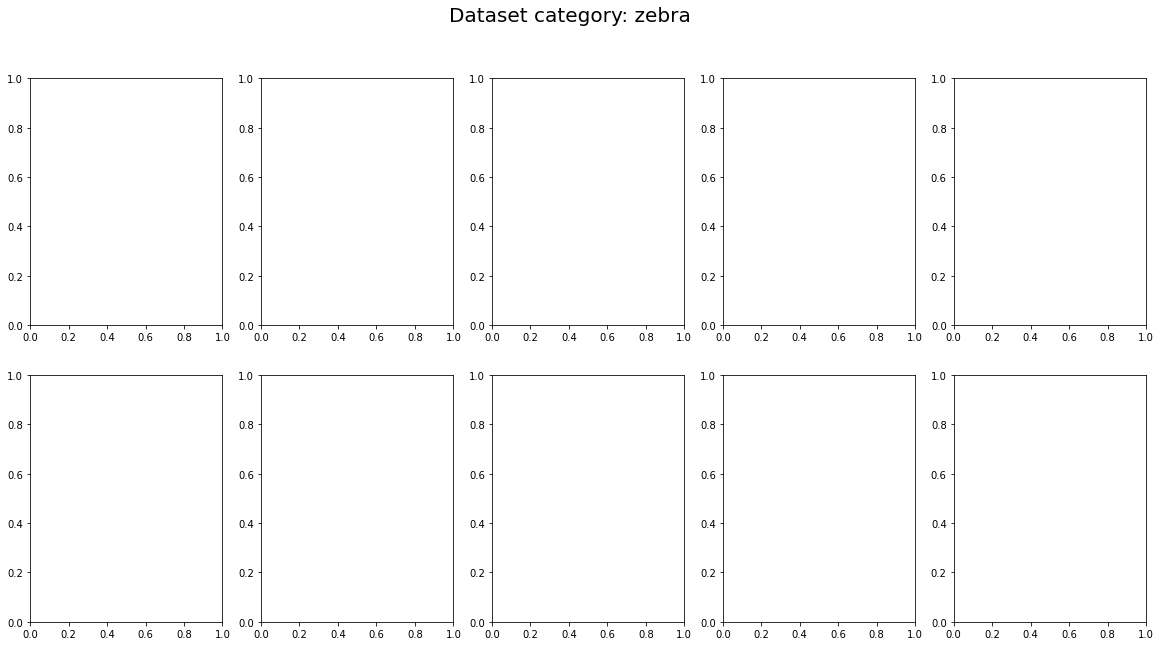

In [106]:
images, sketches = [], []

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle(f'Dataset category: {category}', fontsize=20)
for i in range(5):
    # TODO
    pass

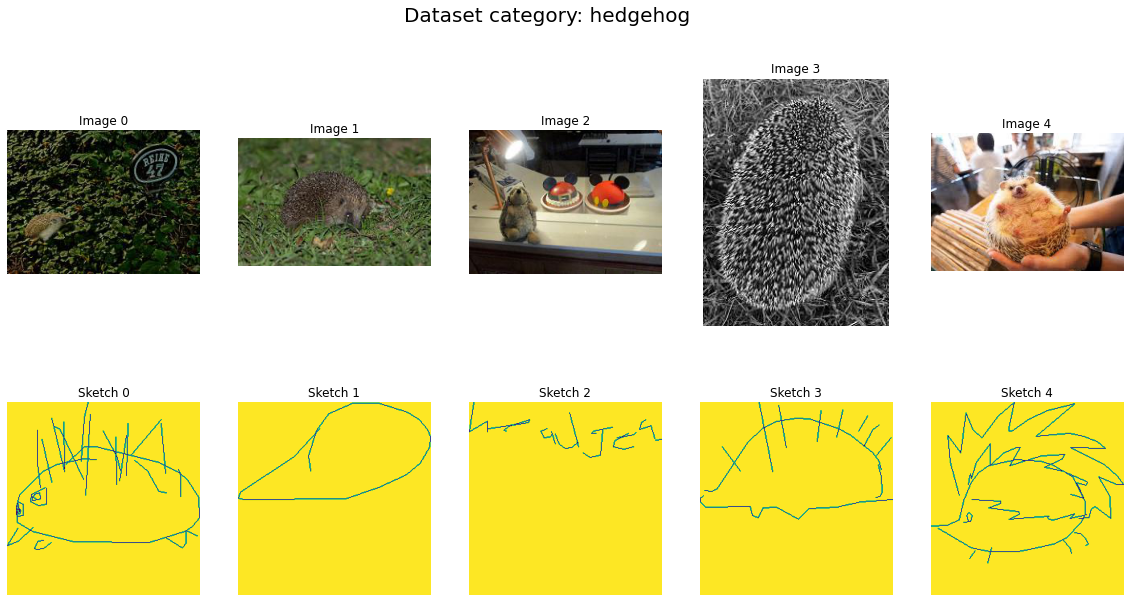

In [23]:
''' Correction '''
images, sketches = [], []

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle(f'Dataset category: {category}', fontsize=20)
for i in range(5):
    sketch = res[f'sketches_{i}_base64']
    image = res[f'images_{i}_base64']
    image = base64_to_array(image)
    sketch = base64_to_array(sketch)
    
    axes[0, i].imshow(image)
    axes[0, i].axis("off");
    axes[0, i].set_title('Image ' + str(i))
    
    axes[1, i].imshow(sketch)
    axes[1, i].axis("off");
    axes[1, i].set_title('Sketch ' + str(i))